<a href="https://colab.research.google.com/github/Francesco-Tagliabue/DL-challenges/blob/main/c2/src/booger_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "giorgiamanioudaki"
os.environ['KAGGLE_KEY'] = "1d894bf85af1afc62f1c89427d9cbf79"
!kaggle competitions download -c an2dl2526c2v2

import zipfile

with zipfile.ZipFile("an2dl2526c2v2.zip", "r") as zip_ref:
    zip_ref.extractall("data")


 99% 926M/936M [00:06<00:00, 250MB/s]
100% 936M/936M [00:06<00:00, 140MB/s]


In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import json

# Path del dataset
DATA_DIR = '/content/data/train_data'

print("✓ Setup completato")


✓ Setup completato


In [ ]:
import hashlib
from collections import defaultdict
from pathlib import Path
import numpy as np
from PIL import Image

data_root = Path(DATA_DIR)

mask_paths = sorted(data_root.glob("mask_*.png"))
groups = defaultdict(list)

def mask_hash(mask_path):
    m = np.array(Image.open(mask_path).convert("L")) > 0
    return hashlib.md5(m.tobytes()).hexdigest()

for mp in mask_paths:
    h = mask_hash(mp)
    groups[h].append(mp)

print("Num unique masks:", len(groups))


Num unique masks: 631


In [ ]:
import shutil

print("Pulizia cartelle di output...")

# Rimuovi TUTTO dalle cartelle di output
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
    print(f"✓ Rimosso: {OUTPUT_DIR}")

if os.path.exists(DEBUG_DIR):
    shutil.rmtree(DEBUG_DIR)
    print(f"✓ Rimosso: {DEBUG_DIR}")

# Ricrea cartelle vuote
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DEBUG_DIR, exist_ok=True)

print("\n✓ Cartelle pulite e ricreate")

Pulizia cartelle di output...

✓ Cartelle pulite e ricreate


In [ ]:
def has_green_booger(image_path, tolerance=30, min_pixels_per_color=50):
    """
    Controlla se l'immagine contiene il booger verde
    TUTTI e 5 i colori devono essere presenti (AND logic)
    """
    img = cv2.imread(str(image_path))
    if img is None:
        return False

    # I 5 colori del booger
    booger_colors_hex = [
        '#36AE00',  # Verde scuro
        '#D2EEDA',  # Verde molto chiaro (highlights)
        '#5AC100',  # Verde lime brillante
        '#3BB100',  # Verde medio
        '#D7EFDB'   # Verde pallido (highlights)
    ]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Conta quanti dei 5 colori sono presenti
    colors_found = 0

    for hex_color in booger_colors_hex:
        # Converti hex a BGR
        hex_clean = hex_color.lstrip('#')
        r = int(hex_clean[0:2], 16)
        g = int(hex_clean[2:4], 16)
        b = int(hex_clean[4:6], 16)

        # Converti BGR pixel singolo a HSV
        bgr_pixel = np.uint8([[[b, g, r]]])
        hsv_pixel = cv2.cvtColor(bgr_pixel, cv2.COLOR_BGR2HSV)[0][0]

        # CONVERTI A INT per evitare overflow
        target_h = int(hsv_pixel[0])
        target_s = int(hsv_pixel[1])
        target_v = int(hsv_pixel[2])

        # Crea range con tolleranza
        h_tolerance = tolerance // 2
        s_tolerance = tolerance * 2
        v_tolerance = tolerance * 2

        # Calcola bounds in int, poi clippa al range valido
        lower_bound = np.array([
            max(0, target_h - h_tolerance),
            max(0, target_s - s_tolerance),
            max(0, target_v - v_tolerance)
        ], dtype=np.uint8)

        upper_bound = np.array([
            min(179, target_h + h_tolerance),
            min(255, target_s + s_tolerance),
            min(255, target_v + v_tolerance)
        ], dtype=np.uint8)

        # Trova pixel che matchano questo colore
        color_mask = cv2.inRange(hsv, lower_bound, upper_bound)
        num_pixels = np.sum(color_mask > 0)

        # Questo colore è presente?
        if num_pixels >= min_pixels_per_color:
            colors_found += 1

    # CONDIZIONE AND: TUTTI e 5 i colori devono essere presenti
    return colors_found == 5


def find_all_booger_images(data_dir):
    """
    Scansiona tutte le immagini e trova quelle con booger
    Richiede che TUTTI e 5 i colori siano presenti
    """
    data_path = Path(data_dir)
    all_images = sorted(list(data_path.glob('img_*.png')) + list(data_path.glob('img_*.jpg')))

    booger_images = []

    print(f"Scanning {len(all_images)} images for boogers (5-color AND method)...")

    for img_path in tqdm(all_images):
        if has_green_booger(img_path):
            booger_images.append(str(img_path))

    print(f"\n✓ Found {len(booger_images)} images with boogers")
    return booger_images


print("✓ Funzioni di detection con 5 colori (AND logic) definite")


✓ Funzioni di detection con 5 colori (AND logic) definite


In [ ]:
# Trova tutte le immagini con booger
booger_image_paths = find_all_booger_images(DATA_DIR)

print(f"\n{'='*60}")
print(f"RISULTATI DETECTION")
print(f"{'='*60}")
print(f"✓ Found {len(booger_image_paths)} images with boogers\n")

# VISUALIZZA LISTA COMPLETA
print("Lista completa delle immagini con booger:")
print("-" * 60)
for i, path in enumerate(booger_image_paths, 1):
    filename = os.path.basename(path)
    print(f"{i:3d}. {filename}")

# Salva lista
os.makedirs(OUTPUT_DIR, exist_ok=True)
with open(os.path.join(OUTPUT_DIR, 'booger_images_list.txt'), 'w') as f:
    f.write('\n'.join([os.path.basename(p) for p in booger_image_paths]))

print(f"\n✓ Lista salvata in: {OUTPUT_DIR}/booger_images_list.txt")


Scanning 691 images for boogers (5-color AND method)...


100%|██████████| 691/691 [00:43<00:00, 15.87it/s]


✓ Found 50 images with boogers

RISULTATI DETECTION
✓ Found 50 images with boogers

Lista completa delle immagini con booger:
------------------------------------------------------------
  1. img_0001.png
  2. img_0012.png
  3. img_0018.png
  4. img_0020.png
  5. img_0028.png
  6. img_0044.png
  7. img_0047.png
  8. img_0052.png
  9. img_0078.png
 10. img_0090.png
 11. img_0094.png
 12. img_0130.png
 13. img_0150.png
 14. img_0161.png
 15. img_0175.png
 16. img_0184.png
 17. img_0222.png
 18. img_0268.png
 19. img_0293.png
 20. img_0333.png
 21. img_0342.png
 22. img_0355.png
 23. img_0368.png
 24. img_0380.png
 25. img_0407.png
 26. img_0453.png
 27. img_0463.png
 28. img_0486.png
 29. img_0497.png
 30. img_0509.png
 31. img_0530.png
 32. img_0531.png
 33. img_0533.png
 34. img_0537.png
 35. img_0557.png
 36. img_0560.png
 37. img_0567.png
 38. img_0578.png
 39. img_0580.png
 40. img_0603.png
 41. img_0629.png
 42. img_0635.png
 43. img_0639.png
 44. img_0643.png
 45. img_0644.png
 4

PREVIEW: Prime 10 immagini con booger

1. img_0001.png
   Shape: (1088, 1024, 3)


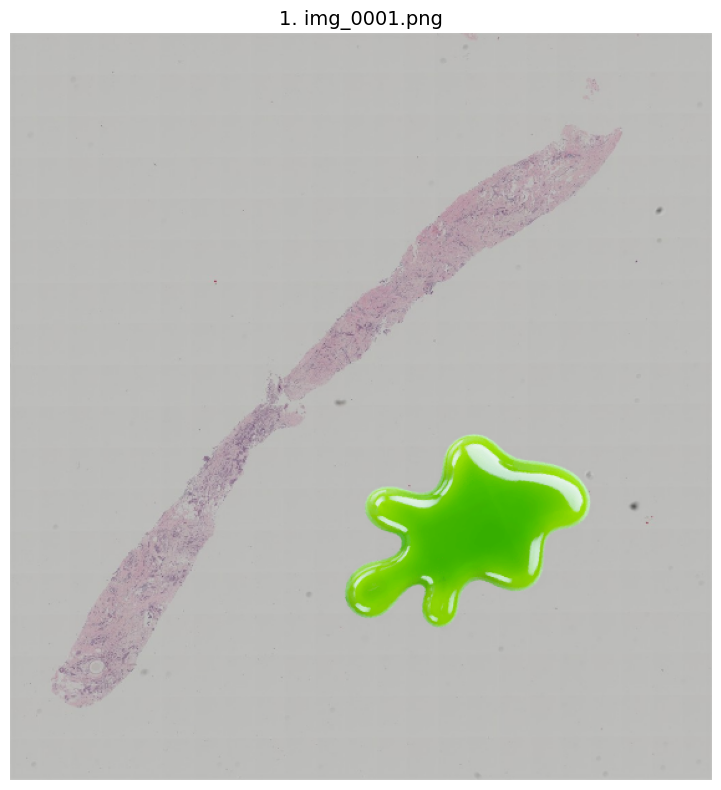

------------------------------------------------------------

2. img_0012.png
   Shape: (1171, 1024, 3)


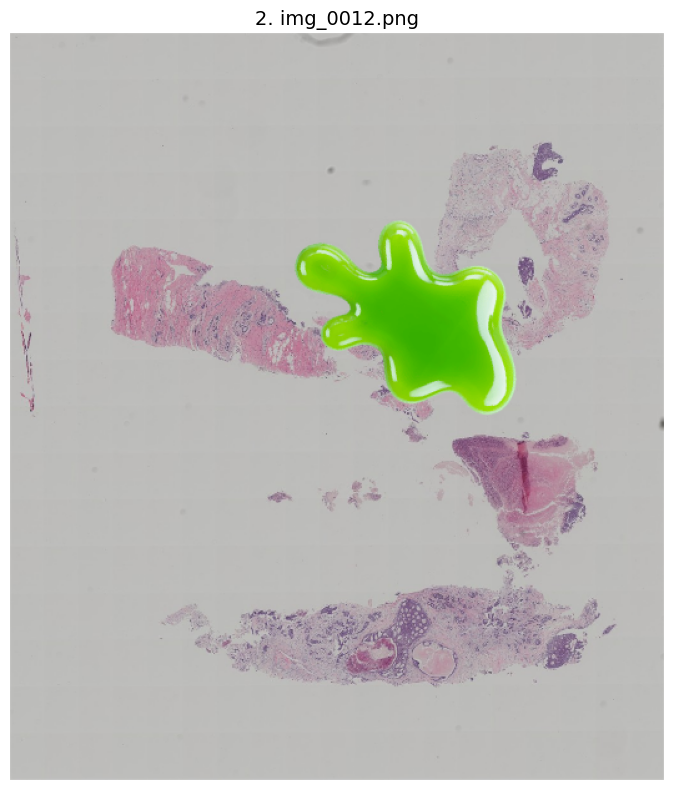

------------------------------------------------------------

3. img_0018.png
   Shape: (1137, 1024, 3)


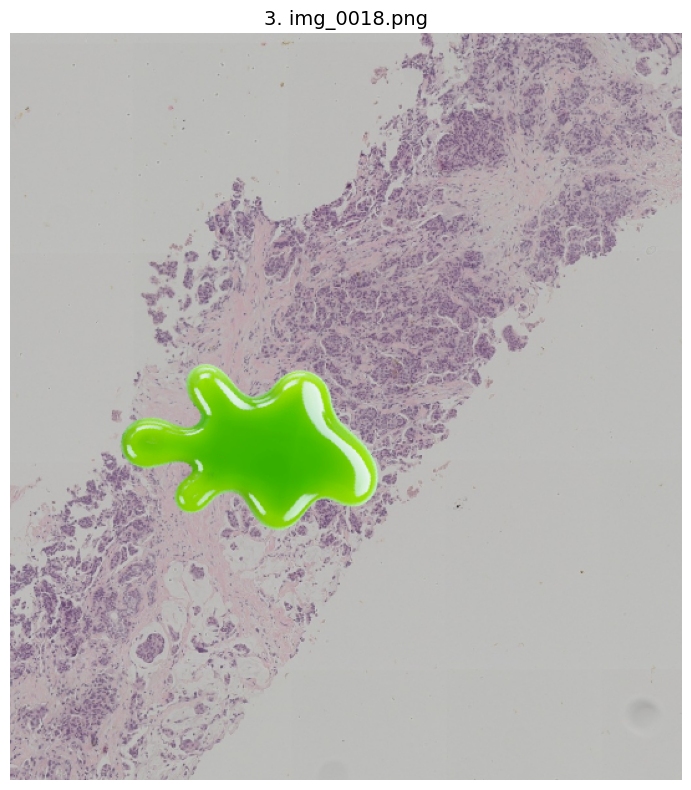

------------------------------------------------------------

4. img_0020.png
   Shape: (1712, 1024, 3)


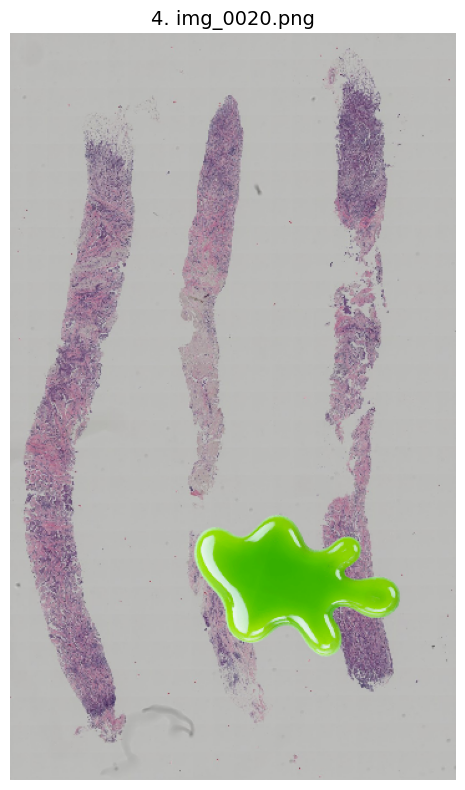

------------------------------------------------------------

5. img_0028.png
   Shape: (1400, 1024, 3)


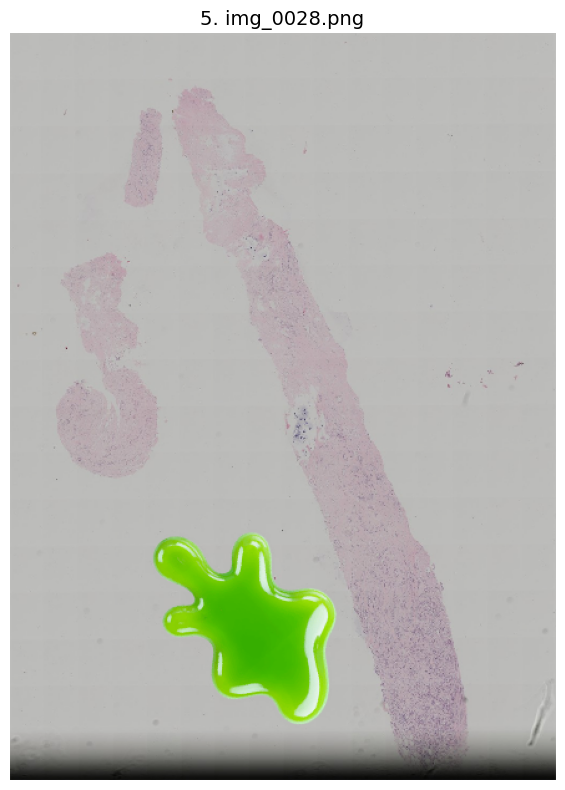

------------------------------------------------------------

6. img_0044.png
   Shape: (1024, 2463, 3)


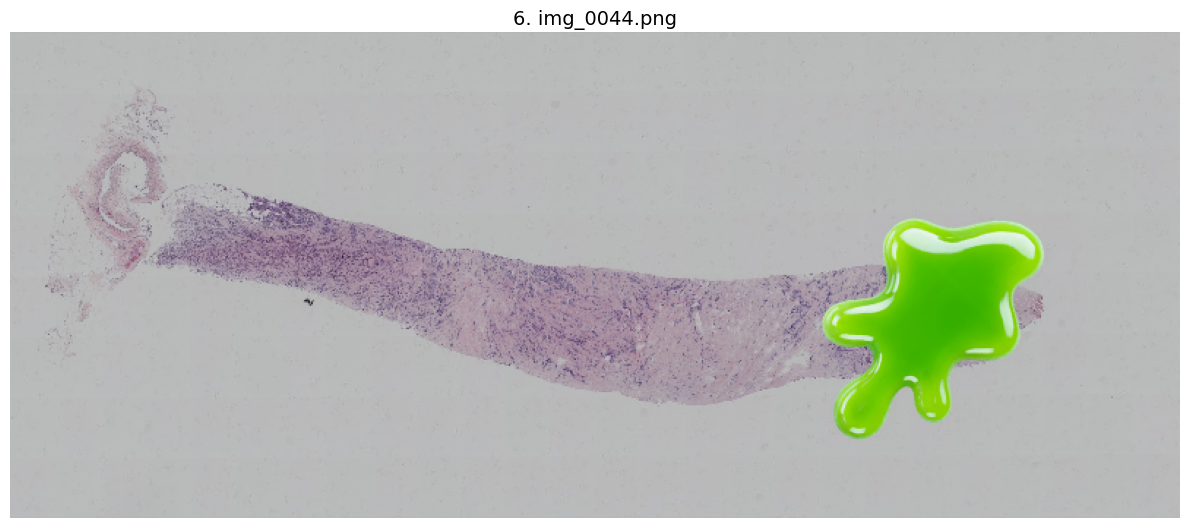

------------------------------------------------------------

7. img_0047.png
   Shape: (1029, 1024, 3)


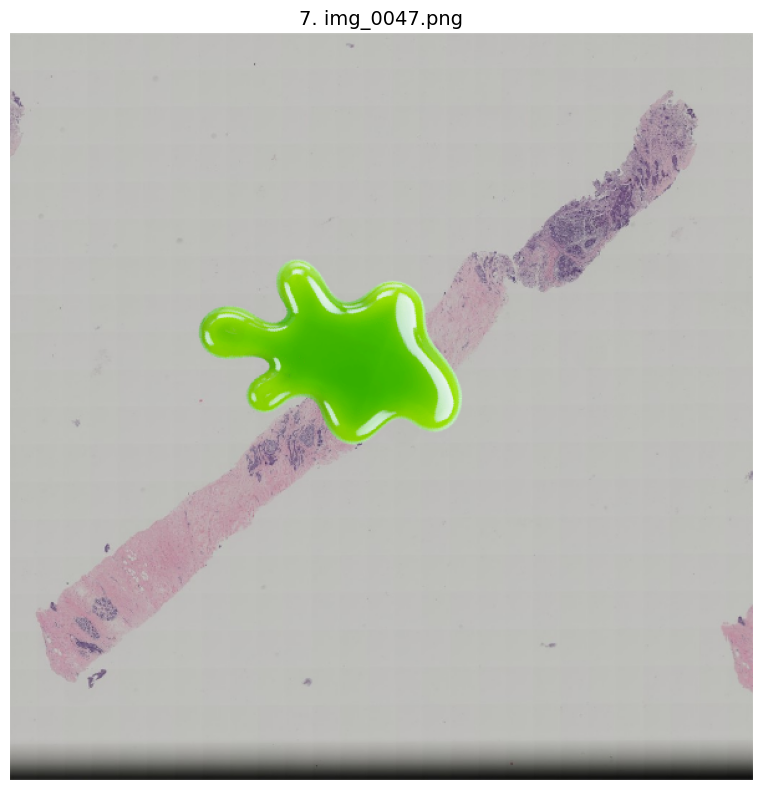

------------------------------------------------------------

8. img_0052.png
   Shape: (1925, 1024, 3)


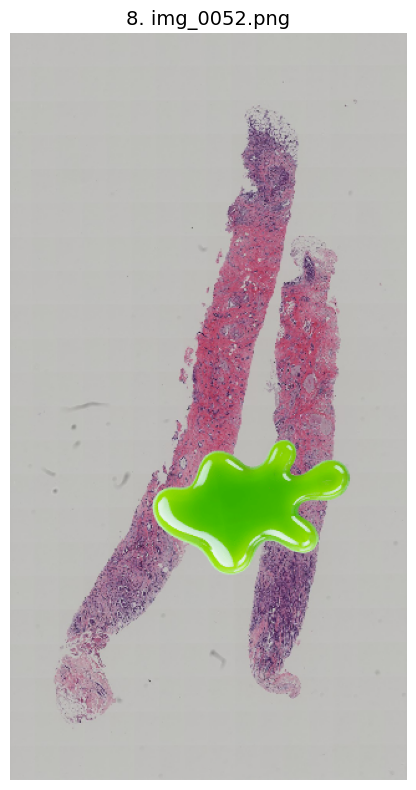

------------------------------------------------------------

9. img_0078.png
   Shape: (1024, 1146, 3)


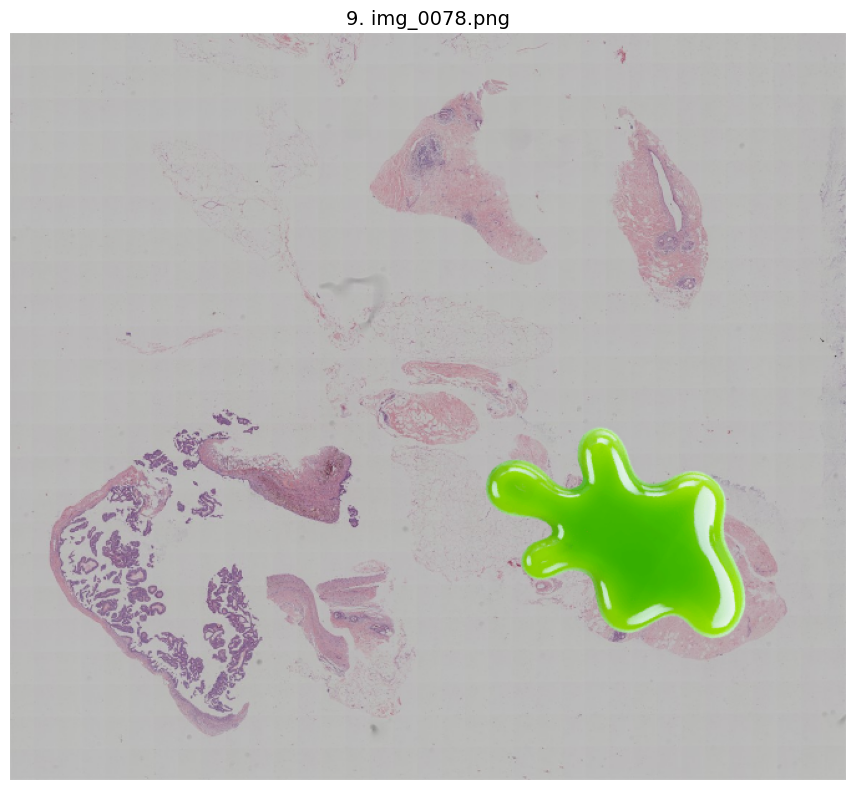

------------------------------------------------------------

10. img_0090.png
   Shape: (1127, 1024, 3)


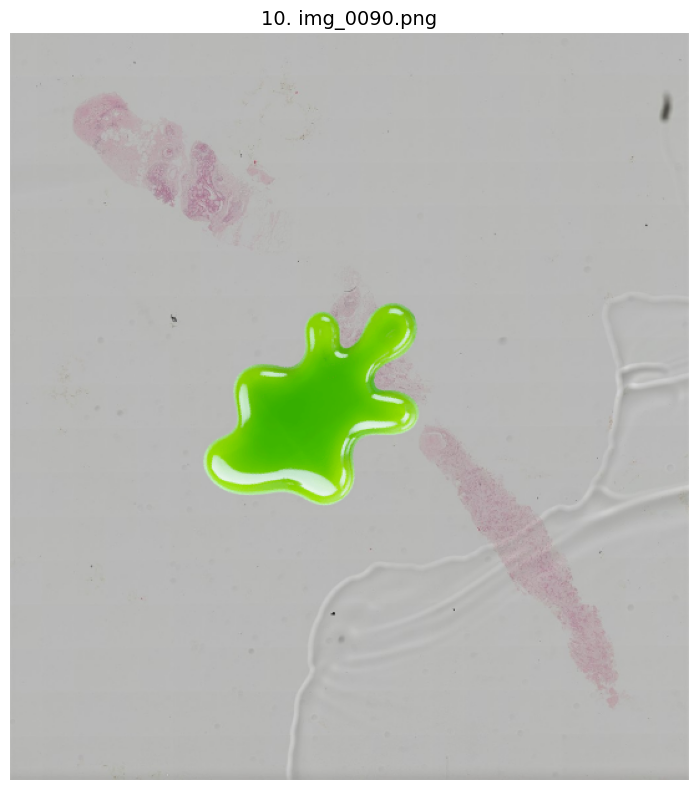

------------------------------------------------------------


In [ ]:
print("PREVIEW: Prime 10 immagini con booger")
print("="*60)

num_to_show = min(10, len(booger_image_paths))

for i, img_path in enumerate(booger_image_paths[:num_to_show]):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    filename = os.path.basename(img_path)
    print(f"\n{i+1}. {filename}")
    print(f"   Shape: {img.shape}")

    # Ridimensiona per visualizzazione migliore
    h, w = img_rgb.shape[:2]
    scale = min(800/w, 600/h, 1.0)
    new_w, new_h = int(w*scale), int(h*scale)
    img_resized = cv2.resize(img_rgb, (new_w, new_h))

    plt.figure(figsize=(12, 8))
    plt.imshow(img_resized)
    plt.title(f"{i+1}. {filename}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("-"*60)


PREVIEW: Prime 10 mask corrispondenti

1. mask_0001.png
   Shape: (1088, 1024)
   Tissue pixels: 68618


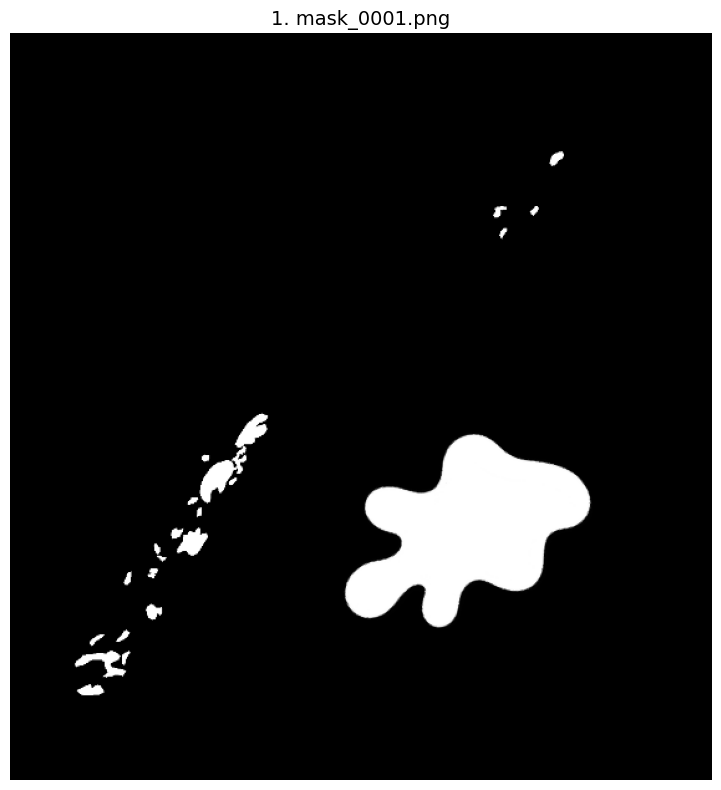

------------------------------------------------------------

2. mask_0012.png
   Shape: (1171, 1024)
   Tissue pixels: 75869


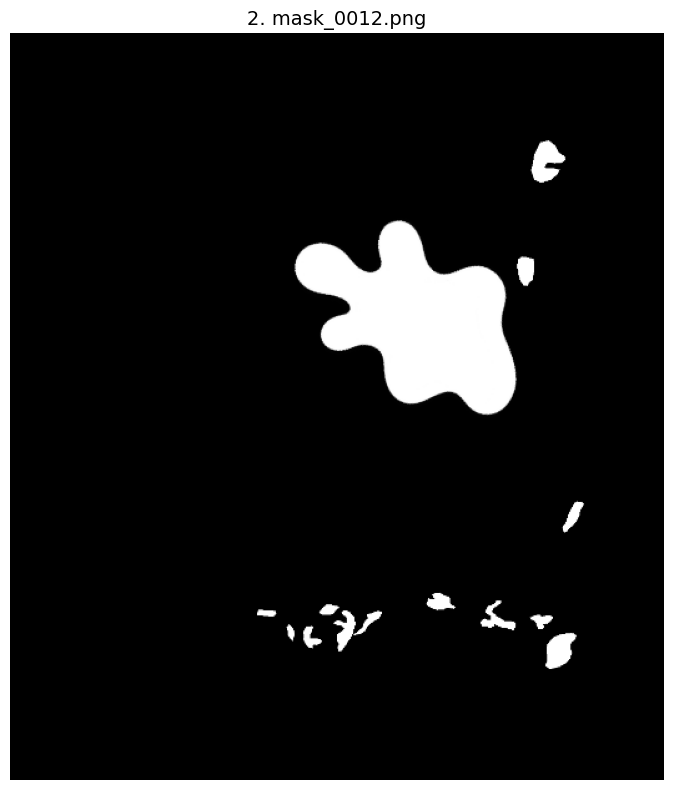

------------------------------------------------------------

3. mask_0018.png
   Shape: (1137, 1024)
   Tissue pixels: 162581


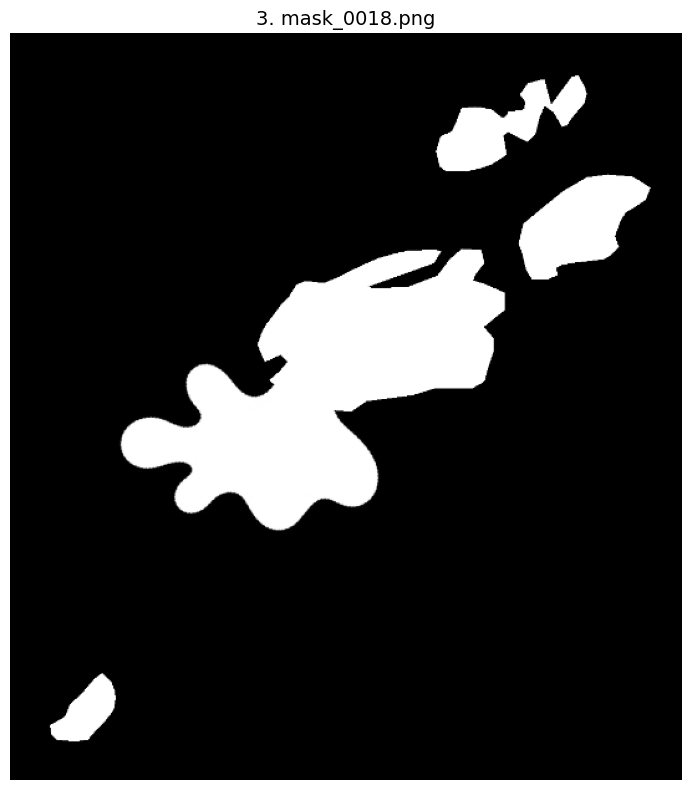

------------------------------------------------------------

4. mask_0020.png
   Shape: (1712, 1024)
   Tissue pixels: 102207


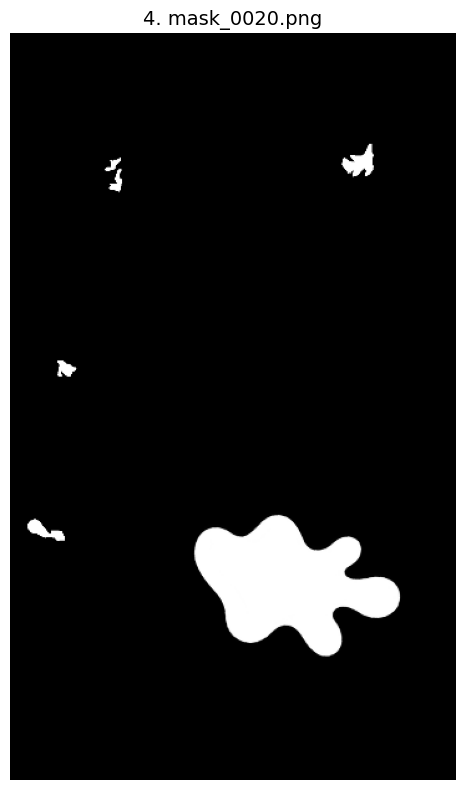

------------------------------------------------------------

5. mask_0028.png
   Shape: (1400, 1024)
   Tissue pixels: 88378


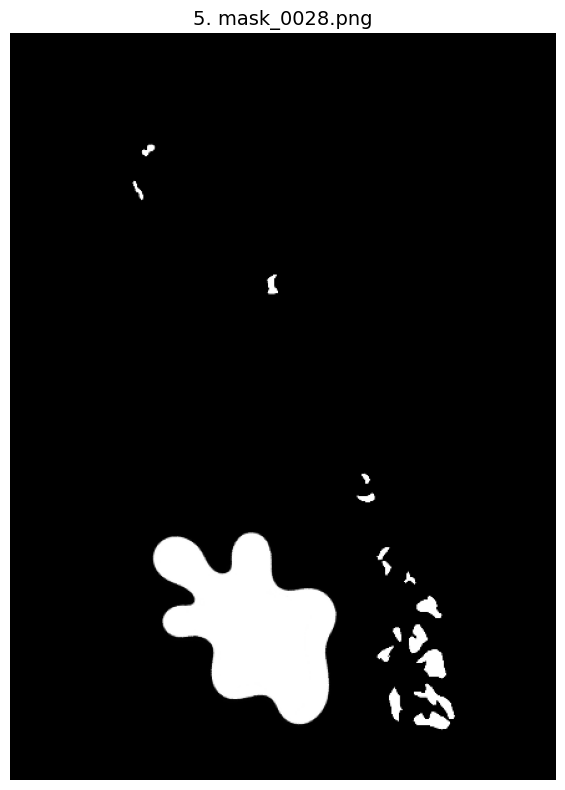

------------------------------------------------------------

6. mask_0044.png
   Shape: (1024, 2463)
   Tissue pixels: 176951


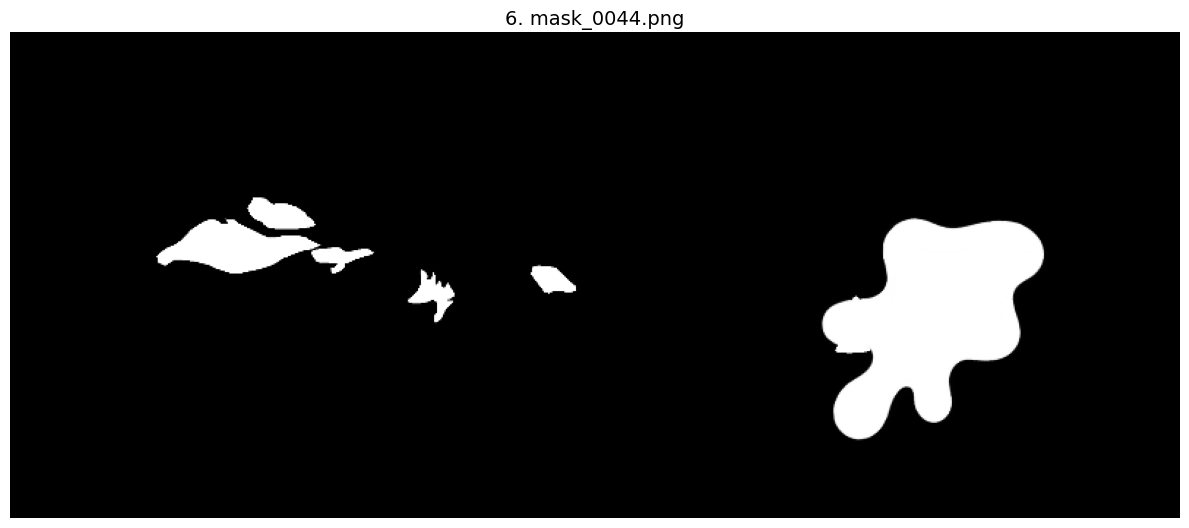

------------------------------------------------------------

7. mask_0047.png
   Shape: (1029, 1024)
   Tissue pixels: 61340


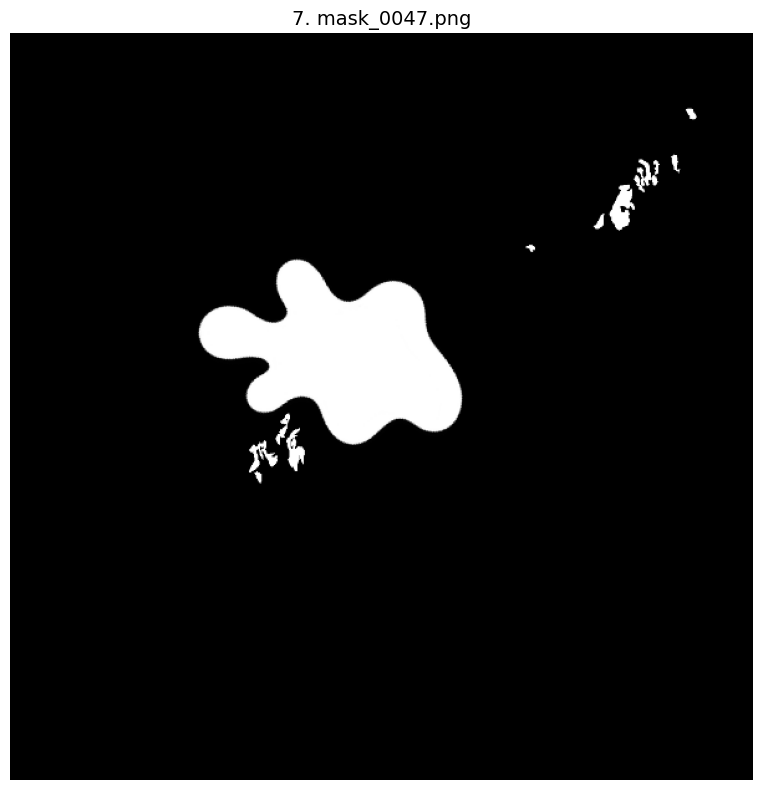

------------------------------------------------------------

8. mask_0052.png
   Shape: (1925, 1024)
   Tissue pixels: 120426


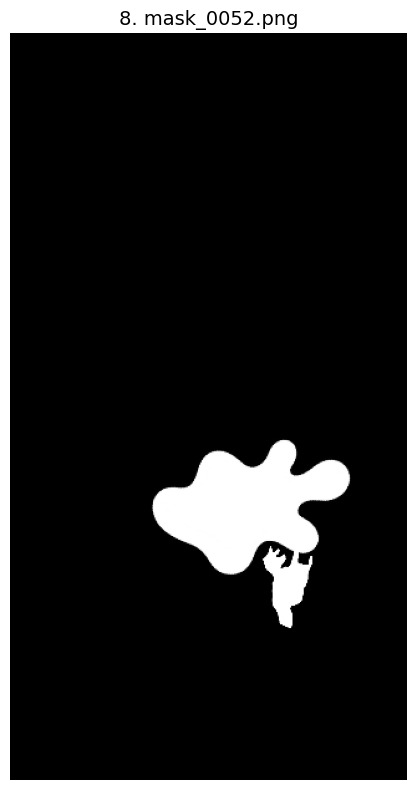

------------------------------------------------------------

9. mask_0078.png
   Shape: (1024, 1146)
   Tissue pixels: 82807


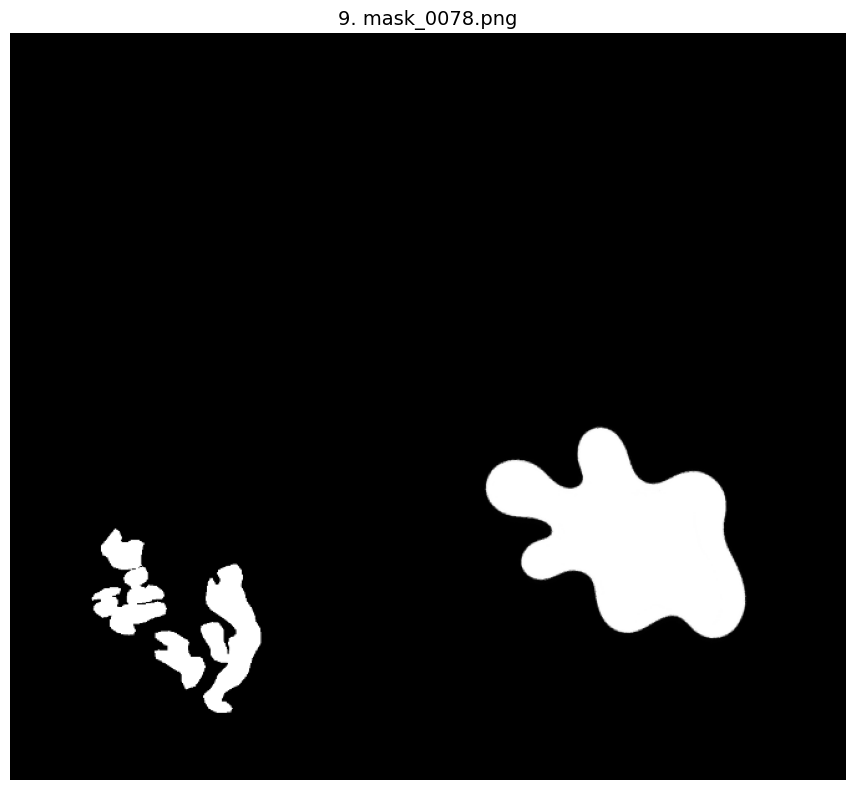

------------------------------------------------------------

10. mask_0090.png
   Shape: (1127, 1024)
   Tissue pixels: 68529


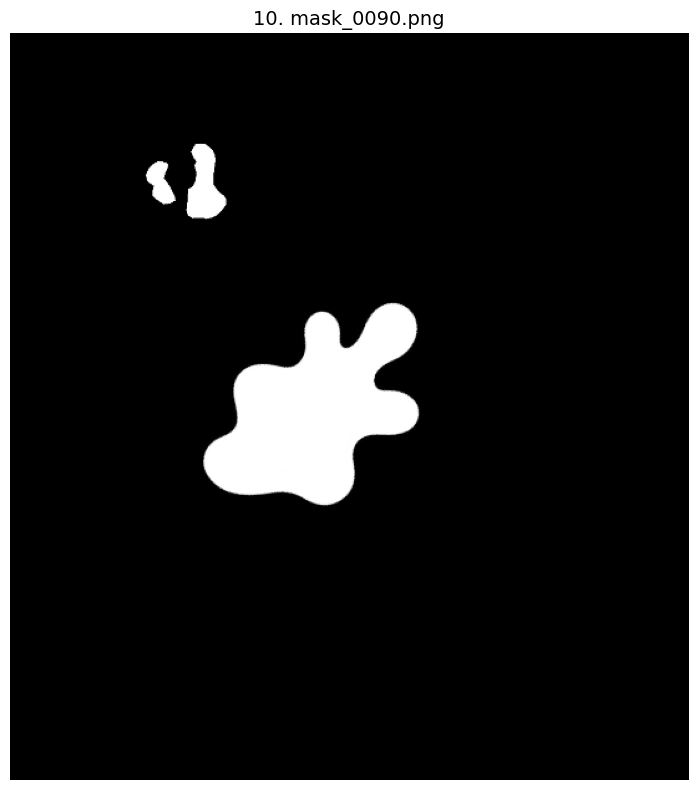

------------------------------------------------------------


In [ ]:
print("PREVIEW: Prime 10 mask corrispondenti")
print("="*60)

num_to_show = min(10, len(booger_image_paths))

for i, img_path in enumerate(booger_image_paths[:num_to_show]):
    img_filename = os.path.basename(img_path)
    mask_filename = img_filename.replace('img_', 'mask_')
    mask_path = os.path.join(DATA_DIR, mask_filename)

    if not os.path.exists(mask_path):
        print(f"{i+1}. {mask_filename} - NOT FOUND")
        continue

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print(f"\n{i+1}. {mask_filename}")
    print(f"   Shape: {mask.shape}")
    print(f"   Tissue pixels: {np.sum(mask > 0)}")

    # Visualizza mask
    h, w = mask.shape
    scale = min(800/w, 600/h, 1.0)
    new_w, new_h = int(w*scale), int(h*scale)
    mask_resized = cv2.resize(mask, (new_w, new_h))

    plt.figure(figsize=(12, 8))
    plt.imshow(mask_resized, cmap='gray')
    plt.title(f"{i+1}. {mask_filename}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("-"*60)
